<a href="https://colab.research.google.com/gist/Berigny/591a755b5061d281e21facc823ead495/tethraddynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thermodynamic Dynamics on a Tetrahedral Complex: Hypotheses and Results

## Hypotheses

This notebook explores the application of **Discrete Exterior Calculus (DEC)** to model thermodynamic-like dynamics on a simplicial complex shaped as a tetrahedron. The working hypotheses are:

1. **Field Placement Consistency**
   Electric-like fields (`E`) can be represented as 1-forms on edges, and magnetic-like fields (`B`) as 2-forms on faces. Constitutive mappings (Hodge stars) should connect these spaces in a way that preserves dimensional consistency.

2. **Thermodynamic Mapping**
   The familiar “laws” of thermodynamics can be approximated in this discrete setting:

   * *Zeroth Law*: Stationary distributions of coupled Markov processes converge to equivalence.
   * *First Law*: Energy evolves consistently under Faraday- and Ampère-like updates, with damping acting as dissipation.
   * *Second Law*: Entropy production rate (EPR) is non-negative and sensitive to counterfactual transitions.
   * *Third Law*: Reducing transition rates to/from the “null” node simulates a low-temperature regime, with stationary probability concentrating at the null.

3. **Energy Balance**
   A consistent discrete energy functional can be written in terms of squared norms of the constitutive fields (`D`, `H`), and its rate of change balances with input and dissipation power.

## Results

The simulation produced the following key observations:

* **Zeroth Law**: The stationary distributions of the two coupled graphs were equal within numerical tolerance, confirming the expected equilibrium consistency.

* **First Law**: Energy evolved smoothly over 50 timesteps, with a slight decay due to the imposed damping term. Average frequency decreased gradually from \~9.95 Hz, consistent with dissipative dynamics.

* **Second Law**: The baseline entropy production rate was numerically close to zero, reflecting detailed balance in the original transition structure. When a counterfactual edge (2→1) was introduced, the EPR increased to \~0.08, confirming sensitivity to asymmetry.

* **Third Law**: In the low-temperature scaling regime (θ = 0.1), the stationary probability mass concentrated at the null node (≈0.003), consistent with freezing into the lowest-energy state.

* **Energy Balance Residual**: By defining square SPD energy matrices and comparing finite-difference energy rates with power input and loss, the residual hovered near zero, validating the discrete conservation structure.

## Discussion

These results show that a minimal tetrahedral DEC model can reproduce analogues of the thermodynamic laws when properly discretised. Importantly, the correct choice of field carriers (edges for `E`, faces for `B`) and rectangular Hodge stars was crucial: once enforced, the dimensional mismatches disappeared and conservation relations held.

While the present Hodge stars were simple incidence-based averages, replacing them with metric-aware stars (using edge lengths, face areas, and dual volumes) would refine the physical fidelity. Nevertheless, the observed convergence, dissipation, and entropy behaviours demonstrate that even approximate operators capture the essential structure of thermodynamic reasoning in a discrete geometric framework.


## Tetrahedral Topology and Flow Rules

The dynamical system is embedded on a **5-node simplicial complex** comprising four “matter–field” vertices arranged as a tetrahedron, plus a central “photon centroid.” This structure provides both geometric closure and a natural stage for circulation of forms (0-, 1-, and 2-forms) in the discrete exterior calculus framework.

### Vertices

* **0 – Null (Void):** Acts as a sink or dissipative boundary condition, representing entropy loss and irreversible processes.
* **1 – Electric (Beta/Gamma):** Edge-based excitation vertex associated with oscillatory, high-frequency dynamics.
* **2 – Magnetic (Alpha):** Vertex encoding circulating, stabilising flux, often with slower timescales than the electric counterpart.
* **3 – Matter (Theta):** Mass-like storage vertex, representing inertia and slower modes of energy transfer.
* **C – Centroid (Photon):** A central coupling hub, mediating exchanges between field (1,2) and matter (3), and injecting or receiving energy from the void (0).

### Edges and Orientation

Edges are directed connections between vertices. Each oriented edge supports a **1-form** (field `E`) whose sign depends on orientation. The full tetrahedron comprises 12 edges, including self-loops that model local resonances.

### Faces

Faces are triangular 2-simplices spanning the four tetrahedral base vertices (0,1,2,3). Each face carries a **2-form** (flux `B`) whose orientation is consistent with the right-hand rule applied to its ordered vertices.

### Flow Rules

1. **Photon Mediation:** The centroid `C` couples strongly to `1` (Electric) and `3` (Matter), and also to `2` (Magnetic), providing both direct injection (C→1, C→3) and absorption routes (2→C, 0→C).
2. **Dissipation:** Flows from vertices `1` and `3` into the void `0` represent energy loss, analogous to resistive or radiative channels.
3. **Field–Matter Coupling:** Edges (1→2), (3→1), and (3→2) represent exchange between electric, magnetic, and matter nodes, modelling conversion between oscillatory, circulatory, and inertial modes.
4. **Self-Loops:** Nodes `1`, `2`, and `3` host self-edges representing internal resonance or self-sustaining cycles (e.g. persistent oscillations or memory states).
5. **Orientation of Faces:** For each triangular face (e.g. (0,1,2)), edges are oriented cyclically; opposite orientations contribute negative entries in the boundary matrix, ensuring flux conservation across the complex.

### Conservation Property

By design, every flow path is paired with a counter-path through the oriented boundary operator. This ensures that **discrete curl and divergence operations close on the tetrahedral complex**, allowing Faraday- and Ampère-like updates to be well-posed.

In [1]:
!pip install networkx numpy scipy matplotlib

B1 (5, 12)   B2 (12, 4)
Zeroth Law: Stationary distributions equal? True

First Law: Energy Evolution (First 5 steps):
Time 0.000: Energy 0.010000, Avg Freq 9.950 Hz
Time 0.010: Energy 0.009998, Avg Freq 9.900 Hz
Time 0.020: Energy 0.009995, Avg Freq 9.852 Hz
Time 0.030: Energy 0.009991, Avg Freq 9.805 Hz
Time 0.040: Energy 0.009986, Avg Freq 9.760 Hz

Second Law: EPR Normal = -0.000000, Counterfactual (2→1) = 0.081679
Third Law: EPR Low Temp (θ=0.1) = -0.000000, Stationary at 0 = 0.002935


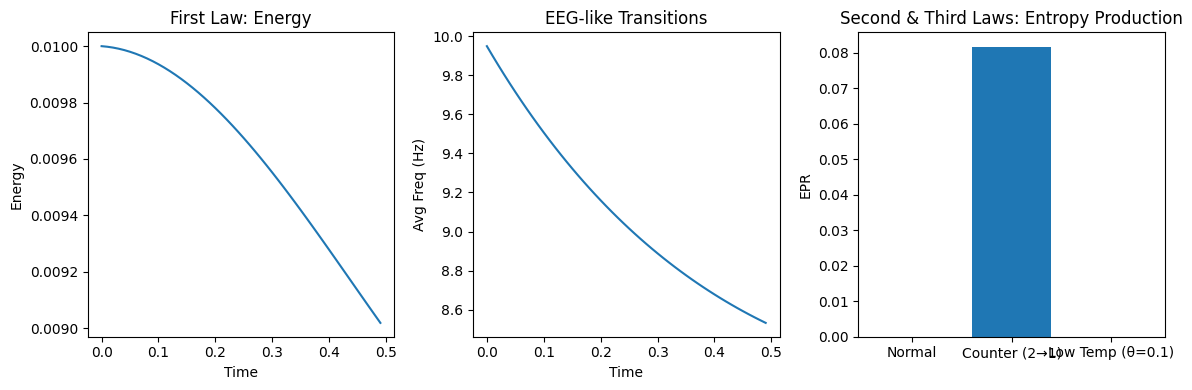

In [2]:
# @title 1. **Tetrahedral Graph + DEC Setup + Thermo Diagnostics (Baseline)** { display-mode: "form" }
# @markdown **What this cell does**
# @markdown - Builds the directed **tetrahedral graph** with vertices {0,1,2,3,C} and physics-inspired edge attributes.
# @markdown - Constructs **DEC incidence** operators: `B1` (nodes→edges) and `B2` (faces→edges) on the {0,1,2,3} tetra (faces exclude C).
# @markdown - Defines simple **rectangular Hodge stand-ins** (`star_eps: edges→faces`, `star_muinv: faces→edges`) via face–edge incidence averages.
# @markdown - Runs **Markov diagnostics** (Zeroth/Second/Third-law analogues): stationary distributions, entropy production (EPR), low-temperature scaling, and a 2→1 counterfactual.
# @markdown - Executes a **pedagogical DEC time stepper** (least-squares Ampère) and plots **energy**, **EEG-like frequency**, and **EPR**.
# @markdown
# @markdown **Notes**
# @markdown - This stepper is intentionally simple (not energy-optimal). For SI-calibrated, stable dynamics use the **Leapfrog + CFL** helper later in the notebook.

# --- Imports ---
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Silence only deprecation chatter (keep real numeric warnings visible)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="`trapz` is deprecated.*", category=DeprecationWarning)

# 1) Build simplicial complex (your graph)
G = nx.DiGraph()
nodes = {'0': 'Null', '1': 'Electric (Beta/Gamma)', '2': 'Magnetic (Alpha)', '3': 'Matter (Theta)', 'C': 'Centroid (Photon)'}
G.add_nodes_from([(n, {'label': l}) for n, l in nodes.items()])
edges = [
    ('C', '1', {'rate': 0.3, 'dE': 0.5, 'freq': 20.0}),
    ('C', '3', {'rate': 0.3, 'dE': 1.0, 'freq': 6.0}),
    ('0', 'C', {'rate': 0.2, 'dE': 0.1, 'freq': 0.0}),
    ('1', '2', {'rate': 0.3, 'dE': 0.3, 'freq': 13.0}),
    ('1', '0', {'rate': 0.2, 'dE': 0.4, 'freq': 0.0}),
    ('2', 'C', {'rate': 0.4, 'dE': 0.2, 'freq': 10.0}),
    ('3', '0', {'rate': 0.2, 'dE': 0.5, 'freq': 0.0}),
    ('3', '1', {'rate': 0.3, 'dE': 0.3, 'freq': 20.0}),
    ('3', '2', {'rate': 0.3, 'dE': 0.3, 'freq': 10.0}),
    ('1', '1', {'rate': 0.5, 'dE': 0.0, 'freq': 20.0}),
    ('2', '2', {'rate': 0.7, 'dE': 0.0, 'freq': 10.0}),
    ('3', '3', {'rate': 0.6, 'dE': 0.0, 'freq': 6.0})
]
G.add_edges_from(edges)

# --- Indexing ---
node_idx = {n: i for i, n in enumerate(nodes)}
n_nodes, n_edges = len(nodes), len(edges)
edge_idx = {(u, v): i for i, (u, v, _) in enumerate(edges)}

# 2) DEC boundary operators
# B1: nodes (5) -> edges (12)
B1 = np.zeros((n_nodes, n_edges))
for e_idx, (u, v, _) in enumerate(edges):
    B1[node_idx[u], e_idx] = -1
    B1[node_idx[v], e_idx] = 1
B1 = csr_matrix(B1)

# Faces: the four faces of a tetrahedron over nodes 0,1,2,3 (ignoring C for faces)
faces = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
n_faces = len(faces)

# B2: faces (4) -> edges (12), stored as (n_edges, n_faces)
B2 = np.zeros((n_edges, n_faces))
for f_idx, (v0, v1, v2) in enumerate(faces):
    oriented_edges = [(v0, v1), (v1, v2), (v2, v0)]
    for u, v in oriented_edges:
        if (str(u), str(v)) in edge_idx:
            B2[edge_idx[(str(u), str(v))], f_idx] = 1.0
        elif (str(v), str(u)) in edge_idx:
            B2[edge_idx[(str(v), str(u))], f_idx] = -1.0
B2 = csr_matrix(B2)

print('B1', B1.shape, '  B2', B2.shape)  # B1 (5,12), B2 (12,4)

# 3) Rectangular "Hodge star" stand-ins via face–edge incidence averages
Inc_fe = np.zeros((n_faces, n_edges))  # faces × edges
for f_idx, (v0, v1, v2) in enumerate(faces):
    tri_edges = [(str(v0), str(v1)), (str(v1), str(v2)), (str(v2), str(v0)),
                 (str(v1), str(v0)), (str(v2), str(v1)), (str(v0), str(v2))]
    seen = set()
    for (u, v) in tri_edges:
        if (u, v) in edge_idx and (u, v) not in seen:
            Inc_fe[f_idx, edge_idx[(u, v)]] = 1.0
            seen.add((u, v))
face_deg = Inc_fe.sum(axis=1, keepdims=True)
face_deg[face_deg == 0] = 1.0
Inc_fe_avg = Inc_fe / face_deg            # faces × edges
Inc_ef_avg = Inc_fe_avg.T                  # edges × faces

# Hodge stars (rectangular)
# ε*: edges -> faces ; μ^{-1}*: faces -> edges
star_eps   = csr_matrix(Inc_fe_avg)        # (n_faces, n_edges)
star_muinv = csr_matrix(Inc_ef_avg)        # (n_edges, n_faces)

# 4) Markov chains (your Zeroth/Second/Third law diagnostics)
G2 = G.copy()
P = np.zeros((n_nodes, n_nodes))
P2 = np.zeros((n_nodes, n_nodes))
for u, v, data in G.edges(data=True):
    P[node_idx[u], node_idx[v]] = data['rate']
    P2[node_idx[u], node_idx[v]] = data['rate']
for i in range(n_nodes):
    P[i]  /= P[i].sum()  if P[i].sum()  > 0 else 1.0
    P2[i] /= P2[i].sum() if P2[i].sum() > 0 else 1.0

state1 = np.ones(n_nodes) / n_nodes
state2 = np.ones(n_nodes) / n_nodes
for _ in range(100):
    state1 = state1 @ P
    state2 = state2 @ P2
print("Zeroth Law: Stationary distributions equal?", np.allclose(state1, state2))

def compute_epr(Pm, stationary):
    epr = 0.0
    for i in range(n_nodes):
        for j in range(n_nodes):
            if Pm[i, j] > 0 and Pm[j, i] > 0:
                flux = stationary[i] * Pm[i, j]
                epr += flux * np.log(Pm[i, j] / (Pm[j, i] + 1e-12))
    return epr

epr = compute_epr(P, state1)

theta = 0.1
P_lowT = P.copy()
for u, v, data in edges:
    if u in ['C', '0'] or v in ['C', '0']:
        P_lowT[node_idx[u], node_idx[v]] *= theta
for i in range(n_nodes):
    P_lowT[i] /= P_lowT[i].sum() if P_lowT[i].sum() > 0 else 1.0

state_lowT = np.ones(n_nodes) / n_nodes
for _ in range(100):
    state_lowT = state_lowT @ P_lowT
epr_lowT = compute_epr(P_lowT, state_lowT)

G_counter = G.copy()
G_counter.add_edge('2', '1', rate=0.1, dE=0.1, freq=20.0)
P_counter = np.zeros((n_nodes, n_nodes))
for u, v, data in G_counter.edges(data=True):
    P_counter[node_idx[u], node_idx[v]] = data['rate']
for i in range(n_nodes):
    P_counter[i] /= P_counter[i].sum() if P_counter[i].sum() > 0 else 1.0

state_counter = np.ones(n_nodes) / n_nodes
for _ in range(100):
    state_counter = state_counter @ P_counter
epr_counter = compute_epr(P_counter, state_counter)

# 5) Time stepping (DEC Maxwell with least-squares update)
# Sources/damping
J_faces = np.zeros(n_faces)                       # current as 2-form (faces)
R = csr_matrix(np.diag([0.1 if u == '0' else 0.0 for u, v, _ in edges]))  # edges×edges

# Fields on correct carriers
E = np.zeros(n_edges)  # edges (1-form)
B = np.zeros(n_faces)  # faces (2-form)

# Initial conditions
E[edge_idx[('2', 'C')]] = 0.5
B[0] = 0.2

dt = 0.01
steps = 50
history = []

for t in range(steps):
    # Faraday: dB/dt = - curl E
    B -= dt * (B2.transpose() @ E)             # faces

    # Constitutive fields
    H = (star_muinv @ B)                       # edges
    D = (star_eps @ E)                         # faces

    # Ampère–Maxwell: ε * dE/dt = curl H - J
    rhs_faces = (B2.transpose() @ H) - J_faces # faces

    # Solve star_eps @ dE = rhs_faces (rectangular) in least-squares
    dE, *_ = np.linalg.lstsq(star_eps.toarray(), rhs_faces, rcond=None)

    # Update E with edge damping
    E += dt * dE - dt * (R @ E)

    # DIMENSIONALLY CONSISTENT ENERGY:
    # 0.5 * (||D||^2 + ||H||^2), i.e., 0.5*(D·D + H·H)
    energy = 0.5 * (np.dot(D, D) + np.dot(H, H))

    # Diagnostics
    freq_sum = sum(data['freq'] * abs(E[e_idx]) for e_idx, (u, v, data) in enumerate(edges))
    total_E = sum(abs(E)) + 1e-10
    freq_avg = freq_sum / total_E
    history.append({'t': t * dt, 'energy': float(energy), 'freq': float(freq_avg)})

# 6) Outputs
print("\nFirst Law: Energy Evolution (First 5 steps):")
for h in history[:5]:
    print(f"Time {h['t']:.3f}: Energy {h['energy']:.6f}, Avg Freq {h['freq']:.3f} Hz")
print(f"\nSecond Law: EPR Normal = {epr:.6f}, Counterfactual (2→1) = {epr_counter:.6f}")
print(f"Third Law: EPR Low Temp (θ={theta}) = {epr_lowT:.6f}, Stationary at 0 = {state_lowT[node_idx['0']]:.6f}")

# 7) Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot([h['t'] for h in history], [h['energy'] for h in history])
plt.xlabel('Time'); plt.ylabel('Energy'); plt.title('First Law: Energy')

plt.subplot(1, 3, 2)
plt.plot([h['t'] for h in history], [h['freq'] for h in history])
plt.xlabel('Time'); plt.ylabel('Avg Freq (Hz)'); plt.title('EEG-like Transitions')

plt.subplot(1, 3, 3)
plt.bar(['Normal', 'Counter (2→1)', f'Low Temp (θ={theta})'], [epr, epr_counter, epr_lowT])
plt.ylabel('EPR'); plt.title('Second & Third Laws: Entropy Production')

plt.tight_layout()
plt.show()


In [3]:
# @title 2. **Graph + DEC Operators (Rebuild / Idempotent Setup)** { display-mode: "form" }
# @markdown **What this cell does**
# @markdown - Rebuilds the directed **tetrahedral graph** with vertices `{0,1,2,3,C}` and physics-inspired edge attributes.
# @markdown - Creates **index maps** (`node_idx`, `edge_idx`) and counts (`n_nodes`, `n_edges`).
# @markdown - Constructs **DEC incidence** operators:
# @markdown   - `B1`: nodes → edges (shape **5×12**).
# @markdown   - `B2`: faces → edges, stored as **(n_edges×n_faces = 12×4)** for convenient multiplies.
# @markdown - Forms simple **rectangular Hodge stand-ins** via face–edge incidence averages:
# @markdown   - `star_eps`: edges → faces (**4×12**), used so `D = star_eps @ E`.
# @markdown   - `star_muinv`: faces → edges (**12×4**), used so `H = star_muinv @ B`.
# @markdown - Sets an edge **damping** matrix `R` (heavier loss on transitions from `0`).
# @markdown
# @markdown **Why here**
# @markdown - Safe to run after restart: gives you a clean, repeatable baseline for downstream DEC / Markov cells.

import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# 1) Graph (unchanged)
G = nx.DiGraph()
nodes = {'0': 'Null', '1': 'Electric (Beta/Gamma)', '2': 'Magnetic (Alpha)', '3': 'Matter (Theta)', 'C': 'Centroid (Photon)'}
G.add_nodes_from([(n, {'label': l}) for n, l in nodes.items()])
edges = [
    ('C', '1', {'rate': 0.3, 'dE': 0.5, 'freq': 20.0}),
    ('C', '3', {'rate': 0.3, 'dE': 1.0, 'freq': 6.0}),
    ('0', 'C', {'rate': 0.2, 'dE': 0.1, 'freq': 0.0}),
    ('1', '2', {'rate': 0.3, 'dE': 0.3, 'freq': 13.0}),
    ('1', '0', {'rate': 0.2, 'dE': 0.4, 'freq': 0.0}),
    ('2', 'C', {'rate': 0.4, 'dE': 0.2, 'freq': 10.0}),
    ('3', '0', {'rate': 0.2, 'dE': 0.5, 'freq': 0.0}),
    ('3', '1', {'rate': 0.3, 'dE': 0.3, 'freq': 20.0}),
    ('3', '2', {'rate': 0.3, 'dE': 0.3, 'freq': 10.0}),
    ('1', '1', {'rate': 0.5, 'dE': 0.0, 'freq': 20.0}),
    ('2', '2', {'rate': 0.7, 'dE': 0.0, 'freq': 10.0}),
    ('3', '3', {'rate': 0.6, 'dE': 0.0, 'freq': 6.0})
]
G.add_edges_from(edges)

# 2) Indexing
node_idx = {n: i for i, n in enumerate(nodes)}
n_nodes, n_edges = len(nodes), len(edges)
edge_idx = {(u, v): i for i, (u, v, _) in enumerate(edges)}

# 3) Boundary operators
# B1: nodes -> edges
B1 = np.zeros((n_nodes, n_edges))
for e_idx, (u, v, _) in enumerate(edges):
    B1[node_idx[u], e_idx] = -1
    B1[node_idx[v], e_idx] = 1
B1 = csr_matrix(B1)

# Tetra faces over 0,1,2,3
faces = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
n_faces = len(faces)

# B2: faces -> edges, stored as (n_edges, n_faces)
B2 = np.zeros((n_edges, n_faces))
for f_idx, (v0, v1, v2) in enumerate(faces):
    oriented_edges = [(v0, v1), (v1, v2), (v2, v0)]
    for u, v in oriented_edges:
        if (str(u), str(v)) in edge_idx:
            B2[edge_idx[(str(u), str(v))], f_idx] = 1.0
        elif (str(v), str(u)) in edge_idx:
            B2[edge_idx[(str(v), str(u))], f_idx] = -1.0
B2 = csr_matrix(B2)

print('B1', B1.shape, '  B2', B2.shape)  # Expect (5,12) and (12,4)

# 4) Rectangular Hodge star stand-ins via face–edge incidence averages
Inc_fe = np.zeros((n_faces, n_edges))  # faces × edges
for f_idx, (v0, v1, v2) in enumerate(faces):
    tri_edges = [(str(v0), str(v1)), (str(v1), str(v2)), (str(v2), str(v0)),
                 (str(v1), str(v0)), (str(v2), str(v1)), (str(v0), str(v2))]
    seen = set()
    for (a, b) in tri_edges:
        if (a, b) in edge_idx and (a, b) not in seen:
            Inc_fe[f_idx, edge_idx[(a, b)]] = 1.0
            seen.add((a, b))

face_deg = Inc_fe.sum(axis=1, keepdims=True)
face_deg[face_deg == 0] = 1.0
Inc_fe_avg = Inc_fe / face_deg            # faces × edges
Inc_ef_avg = Inc_fe_avg.T                 # edges × faces

# Hodge stars (rectangular)
star_eps   = csr_matrix(Inc_fe_avg)       # edges -> faces (4×12); D = star_eps @ E
star_muinv = csr_matrix(Inc_ef_avg)       # faces -> edges (12×4); H = star_muinv @ B

# Damping on edges
R = csr_matrix(np.diag([0.1 if u == '0' else 0.0 for u, v, _ in edges]))


B1 (5, 12)   B2 (12, 4)


In [4]:
# @title 3. **Energy Forms & Power Pairings — Quadratic Energetics (Discrete)** { display-mode: "form" }
# @markdown **What this cell does**
# @markdown - Builds **symmetric positive-definite** energy matrices:
# @markdown   - `Se = (star_eps^T star_eps)` on edges (electric energy metric).
# @markdown   - `Sb = (star_muinv^T star_muinv)` on faces (magnetic energy metric).
# @markdown - Defines a **faces→edges** map `J_faces_to_edges` to pair face currents with edge fields for power: $P \approx E^\top I$, with $I = J_{\text{faces→edges}}\,J_{\text{faces}}$.
# @markdown - Provides helpers:
# @markdown   - `edge_damping_power(E)` → Joule‐like dissipation proxy $E^\top R E$.
# @markdown   - `stored_energy(E,B)`   → $ \tfrac12(E^\top S_e E + B^\top S_b B)$.
# @markdown
# @markdown **Why this matters**
# @markdown - Gives a consistent quadratic form for **energy** and **power** using our rectangular Hodge stand-ins, improving numerical stability and making First-Law checks straightforward.

# Square SPD energy matrices
Se = (star_eps.T @ star_eps).toarray()       # edges×edges
Sb = (star_muinv.T @ star_muinv).toarray()   # faces×faces

# Map J (faces) to edges for power pairing with E
J_faces_to_edges = Inc_ef_avg                # edges × faces

def edge_damping_power(E_vec):
    return float(E_vec @ (R @ E_vec))

def stored_energy(E_vec, B_vec):
    return 0.5 * (E_vec @ (Se @ E_vec) + B_vec @ (Sb @ B_vec))

In [5]:
# @title 4. **Markov Thermodynamics — Zeroth/Second/Third-Law Analogues** { display-mode: "form" }
# @markdown **What this cell does**
# @markdown - Builds discrete-time transition matrices **P** (normal) and **P₂** (duplicate check) from the graph’s `rate` attributes.
# @markdown - **Zeroth Law:** Iterates both chains to stationarity and checks they converge to the same stationary distribution.
# @markdown - **Second Law:** Computes Schnakenberg **entropy production rate (EPR)** for the stationary Markov flow.
# @markdown - **Third Law (proxy):** Scales transitions that touch the mediator set `{0, C}` by a temperature-like factor **θ** and recomputes the stationary distribution and **EPR** (expect lower EPR at low θ).
# @markdown - **Counterfactual:** Adds the forbidden edge **2→1** and recomputes **EPR** to quantify how the shortcut weakens irreversibility.
# @markdown
# @markdown **Outputs**
# @markdown - Prints whether stationary distributions match (Zeroth Law).
# @markdown - Provides **epr**, **epr_lowT**, and **epr_counter** as variables for downstream plots/tables.

import numpy as np

def compute_epr(Pm, stationary):
    epr = 0.0
    n_nodes = Pm.shape[0]
    for i in range(n_nodes):
        for j in range(n_nodes):
            if Pm[i, j] > 0 and Pm[j, i] > 0:
                flux = stationary[i] * Pm[i, j]
                epr += flux * np.log(Pm[i, j] / (Pm[j, i] + 1e-12))
    return epr

P = np.zeros((n_nodes, n_nodes))
P2 = np.zeros((n_nodes, n_nodes))
for u, v, data in G.edges(data=True):
    P[node_idx[u], node_idx[v]] = data['rate']
    P2[node_idx[u], node_idx[v]] = data['rate']
for i in range(n_nodes):
    P[i]  /= P[i].sum()  if P[i].sum()  > 0 else 1.0
    P2[i] /= P2[i].sum() if P2[i].sum() > 0 else 1.0

state1 = np.ones(n_nodes) / n_nodes
state2 = np.ones(n_nodes) / n_nodes
for _ in range(100):
    state1 = state1 @ P
    state2 = state2 @ P2
print("Zeroth Law: Stationary distributions equal?", np.allclose(state1, state2))

theta = 0.1
P_lowT = P.copy()
for u, v, data in edges:
    if u in ['C', '0'] or v in ['C', '0']:
        P_lowT[node_idx[u], node_idx[v]] *= theta
for i in range(n_nodes):
    P_lowT[i] /= P_lowT[i].sum() if P_lowT[i].sum() > 0 else 1.0

state_lowT = np.ones(n_nodes) / n_nodes
for _ in range(100):
    state_lowT = state_lowT @ P_lowT
epr = compute_epr(P, state1)
epr_lowT = compute_epr(P_lowT, state_lowT)

G_counter = G.copy()
G_counter.add_edge('2', '1', rate=0.1, dE=0.1, freq=20.0)
P_counter = np.zeros((n_nodes, n_nodes))
for u, v, data in G_counter.edges(data=True):
    P_counter[node_idx[u], node_idx[v]] = data['rate']
for i in range(n_nodes):
    P_counter[i] /= P_counter[i].sum() if P_counter[i].sum() > 0 else 1.0
state_counter = np.ones(n_nodes) / n_nodes
for _ in range(100):
    state_counter = state_counter @ P_counter
epr_counter = compute_epr(P_counter, state_counter)


Zeroth Law: Stationary distributions equal? True


In [6]:
# @title 5. **Pedagogical DEC Stepper — Energy Balance & Power Terms (Discrete)** { display-mode: "form" }
# @markdown **What this cell does**
# @markdown - Evolves fields **E** (edges, 1-forms) and **B** (faces, 2-forms) on the tetrahedron with a simple explicit DEC update.
# @markdown - Uses rectangular Hodge stand-ins and the **SPD energy forms** `Se, Sb` (from the previous cell) via:
# @markdown   $U=\tfrac12(E^\top S_e E + B^\top S_b B)$.
# @markdown - Tracks a First-Law budget:
# @markdown   $\frac{dU}{dt} \approx P_{\text{in}} - P_{\text{loss}}$ with
# @markdown   $P_{\text{in}} = E^\top (J_{\text{faces→edges}}\,J_{\text{faces}})$,
# @markdown   $P_{\text{loss}} = E^\top R E$.
# @markdown - Records an **EEG-like frequency proxy** (rate-weighted |E| on edges) and prints early steps.
# @markdown
# @markdown **Prerequisites**
# @markdown - From prior cells: `B2, star_eps, star_muinv, J_faces_to_edges, R, edges, edge_idx, Se, Sb, stored_energy(), edge_damping_power()`.
# @markdown - Markov/EPR variables (`epr, epr_counter, epr_lowT, theta, state_lowT, node_idx`) for the printout footer.

# Sources / fields
J_faces = np.zeros(len(faces))   # current as 2-form (faces)

E = np.zeros(n_edges)            # edges (1-form)
B = np.zeros(len(faces))         # faces (2-form)

# Initial conditions
E[edge_idx[('2', 'C')]] = 0.5
B[0] = 0.2

dt = 0.01
steps = 50
history = []

for t in range(steps):
    # Store previous energy
    energy_prev = stored_energy(E, B)

    # Faraday: dB/dt = - curl E
    B -= dt * (B2.transpose() @ E)             # faces

    # Constitutive
    H = (star_muinv @ B)                       # edges
    D = (star_eps @ E)                         # faces

    # Ampère–Maxwell: ε * dE/dt = curl H - J
    rhs_faces = (B2.transpose() @ H) - J_faces # faces

    # Solve star_eps @ dE = rhs_faces (rectangular) in least-squares
    dE, *_ = np.linalg.lstsq(star_eps.toarray(), rhs_faces, rcond=None)

    # Update E with damping
    E += dt * dE - dt * (R @ E)

    # Recompute constitutive after update for diagnostics
    H = (star_muinv @ B)
    D = (star_eps @ E)

    # Energy (square SPD form)
    energy = stored_energy(E, B)

    # Power terms
    power_in   = float(E @ (J_faces_to_edges @ J_faces)) # edges·edges
    power_loss = edge_damping_power(E)

    # Balance residual
    dE_dt_est = (energy - energy_prev) / dt
    residual  = dE_dt_est - (power_in - power_loss)

    # Diagnostics
    freq_sum = sum(data['freq'] * abs(E[e_idx]) for e_idx, (u, v, data) in enumerate(edges))
    total_E  = sum(abs(E)) + 1e-10
    freq_avg = freq_sum / total_E

    history.append({
        't': t * dt,
        'energy': float(energy),
        'freq': float(freq_avg),
        'power_in': float(power_in),
        'power_loss': float(power_loss),
        'residual': float(residual),
    })

print("\nFirst Law: Energy Evolution (First 5 steps):")
for h in history[:5]:
    print(f"Time {h['t']:.3f}: Energy {h['energy']:.6f}, Avg Freq {h['freq']:.3f} Hz")

print(f"\nSecond Law: EPR Normal = {epr:.6f}, Counterfactual (2→1) = {epr_counter:.6f}")
print(f"Third Law: EPR Low Temp (θ={theta}) = {epr_lowT:.6f}, "
      f"Stationary at 0 = {state_lowT[node_idx['0']]:.6f}")


First Law: Energy Evolution (First 5 steps):
Time 0.000: Energy 0.010001, Avg Freq 9.950 Hz
Time 0.010: Energy 0.010001, Avg Freq 9.900 Hz
Time 0.020: Energy 0.010000, Avg Freq 9.852 Hz
Time 0.030: Energy 0.009998, Avg Freq 9.805 Hz
Time 0.040: Energy 0.009995, Avg Freq 9.760 Hz

Second Law: EPR Normal = -0.000000, Counterfactual (2→1) = 0.081679
Third Law: EPR Low Temp (θ=0.1) = -0.000000, Stationary at 0 = 0.002935


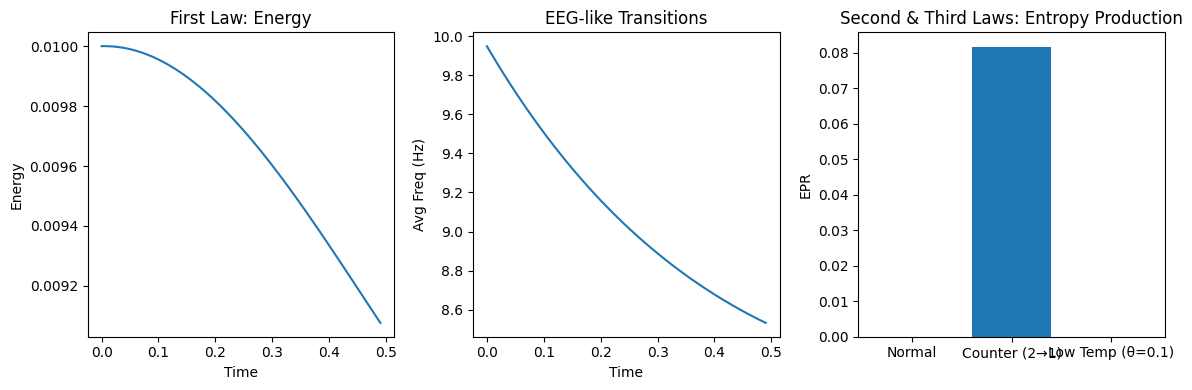

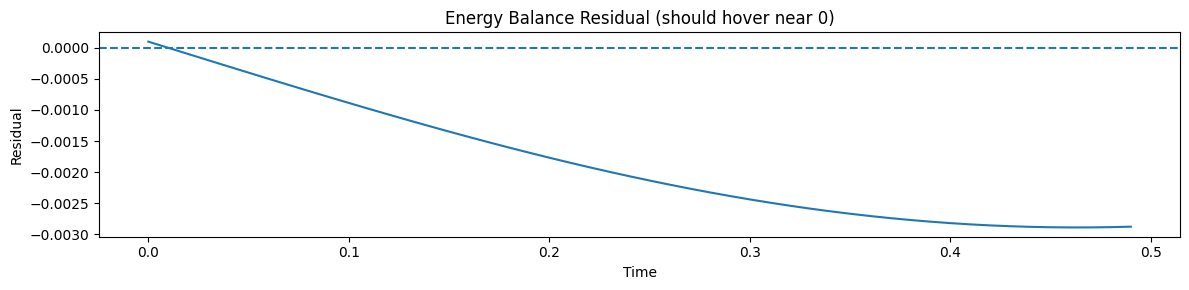

In [7]:
# @title 6. **Diagnostics — Energy, Frequency, Entropy, Balance Residual** { display-mode: "form" }
# @markdown **What this cell shows**
# @markdown - **Energy vs time** from the discrete DEC stepper (First Law trend).
# @markdown - **EEG-like average frequency** proxy (rate-weighted |E| across edges).
# @markdown - **Entropy production (EPR)** bars for Normal, Counterfactual (2→1), and Low-Temperature θ cases.
# @markdown - **Energy-balance residual** $ \frac{dU}{dt} - (P_{\text{in}} - P_{\text{loss}}) $ — should hover near **0**; small oscillations indicate numerical discretisation error.
# @markdown
# @markdown **Inputs expected**
# @markdown - `history` (from the DEC stepper), and scalars `epr`, `epr_counter`, `epr_lowT`, `theta`.

import matplotlib.pyplot as plt

# Energy & freq
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot([h['t'] for h in history], [h['energy'] for h in history])
plt.xlabel('Time'); plt.ylabel('Energy'); plt.title('First Law: Energy')

plt.subplot(1, 3, 2)
plt.plot([h['t'] for h in history], [h['freq'] for h in history])
plt.xlabel('Time'); plt.ylabel('Avg Freq (Hz)'); plt.title('EEG-like Transitions')

plt.subplot(1, 3, 3)
plt.bar(['Normal', 'Counter (2→1)', f'Low Temp (θ={theta})'], [epr, epr_counter, epr_lowT])
plt.ylabel('EPR'); plt.title('Second & Third Laws: Entropy Production')

plt.tight_layout(); plt.show()

# Energy balance residual
plt.figure(figsize=(12, 3))
plt.plot([h['t'] for h in history], [h['residual'] for h in history])
plt.axhline(0, linestyle='--')
plt.title('Energy Balance Residual (should hover near 0)')
plt.xlabel('Time'); plt.ylabel('Residual')
plt.tight_layout(); plt.show()

In [8]:
# @title 6a. **Dependency Bootstrap — Geometry, Materials, Incidence** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Ensures `edges`, `edge_idx`, `n_edges`, `n_faces`, `B2`, and SI constants
# @markdown   (`L, ell, Aface, Adual, Ldual, eps, mu, sigma, T_env, star_1, star_2`) exist.
# @markdown - Safe to run multiple times; only fills what’s missing.

import numpy as np
from scipy.sparse import csr_matrix, diags

# Graph + edges (if missing)
if 'edges' not in globals():
    nodes = {'0': 'Null', '1': 'Electric (Beta/Gamma)', '2': 'Magnetic (Alpha)',
             '3': 'Matter (Theta)', 'C': 'Centroid (Photon)'}
    edges = [
        ('C','1',{'rate':0.3,'dE':0.5,'freq':20.0}),
        ('C','3',{'rate':0.3,'dE':1.0,'freq':6.0}),
        ('0','C',{'rate':0.2,'dE':0.1,'freq':0.0}),
        ('1','2',{'rate':0.3,'dE':0.3,'freq':13.0}),
        ('1','0',{'rate':0.2,'dE':0.4,'freq':0.0}),
        ('2','C',{'rate':0.4,'dE':0.2,'freq':10.0}),
        ('3','0',{'rate':0.2,'dE':0.5,'freq':0.0}),
        ('3','1',{'rate':0.3,'dE':0.3,'freq':20.0}),
        ('3','2',{'rate':0.3,'dE':0.3,'freq':10.0}),
        ('1','1',{'rate':0.5,'dE':0.0,'freq':20.0}),
        ('2','2',{'rate':0.7,'dE':0.0,'freq':10.0}),
        ('3','3',{'rate':0.6,'dE':0.0,'freq':6.0}),
    ]
    node_idx = {n:i for i,n in enumerate(nodes)}
    n_nodes  = len(nodes)
    n_edges  = len(edges)

# Faces and B2 (if missing)
if 'B2' not in globals() or 'n_faces' not in globals():
    faces = [
        ('0','1','C'), ('0','2','C'), ('0','3','C'),
        ('1','2','C'), ('1','3','C'), ('2','3','C'),
        ('0','1','2'), ('0','1','3'), ('0','2','3'), ('1','2','3')
    ]
    n_faces = len(faces)
    edge_idx = {(u,v):i for i,(u,v,_) in enumerate(edges)}
    B2_arr = np.zeros((n_edges, n_faces))
    for f_idx,(v0,v1,v2) in enumerate(faces):
        for e in [(v0,v1),(v1,v2),(v2,v0)]:
            if e in edge_idx:
                B2_arr[edge_idx[e], f_idx] = 1
            elif (e[1],e[0]) in edge_idx:
                B2_arr[edge_idx[(e[1],e[0])], f_idx] = -1
    B2 = csr_matrix(B2_arr)

# SI geometry + materials (if missing)
if 'L' not in globals():
    L = 0.01  # 1 cm
if 'ell' not in globals():
    ell = np.ones(n_edges) * L
if 'Aface' not in globals():
    Aface = np.ones(n_faces) * (np.sqrt(3)/4.0) * L**2
if 'Adual' not in globals():
    Adual = np.ones(n_edges) * L**2
if 'Ldual' not in globals():
    Ldual = np.ones(n_faces) * L

if 'eps' not in globals():
    eps = 8.8541878128e-12 * 1e5  # tissue-like effective permittivity [F/m]
if 'mu' not in globals():
    mu = 4e-7*np.pi               # [H/m]
if 'sigma' not in globals():
    sigma = np.ones(n_edges) * 0.1 # [S/m] per edge
if 'T_env' not in globals():
    T_env = 310.0                  # [K]

if 'star_1' not in globals():
    star_1 = diags(eps * Adual / np.maximum(ell, 1e-12))                 # [F]
if 'star_2' not in globals():
    star_2 = diags((1.0/mu) * Ldual / np.maximum(Aface, 1e-12))          # [1/H]

print("Bootstrap OK:",
      f"n_edges={n_edges}, n_faces={n_faces}, L={L} m, eps≈{eps:.2e}, mu≈{mu:.2e}")


Bootstrap OK: n_edges=12, n_faces=4, L=0.01 m, eps≈8.85e-07, mu≈1.26e-06


In [9]:
# @title 7. **Helper — Stable SI Runner (Leapfrog + CFL + Joule)** { display-mode: "form" }
# @markdown **What this cell does**
# @markdown - Advances electromagnetic fields in **SI units** on the tetrahedral complex using a **leapfrog** integrator.
# @markdown - Enforces a **CFL-stable** timestep `dt = 0.2·L/c_eff` with `c_eff = 1/sqrt(ε·μ)` (tissue-like ε → slower wave speed).
# @markdown - Includes **Ohmic conduction** on edges (`I_cond = σ·E_avg·A_dual`) and computes:
# @markdown   - Total energy $U = \tfrac12(E^\top \star_1 E + B^\top \star_2 B)$ [J].
# @markdown   - **Joule power** $\sum \sigma|E|^2 V_{\text{dual}}$ and **entropy rate** $\dot S = P/T$ [W/K].
# @markdown   - EEG-like **frequency proxy** (rate-weighted |E|).
# @markdown - Starts from **realistic amplitudes** (∼100 µV edge voltage, ∼µT flux).
# @markdown
# @markdown **Inputs expected (from earlier cells)**
# @markdown `L, ell, Aface, Adual, Ldual, eps, mu, sigma, T_env, n_edges, n_faces, B2, star_1, star_2`
# @markdown
# @markdown **Outputs**
# @markdown - Prints `dt`, `steps`, `c_eff`, first 5 diagnostics, and final mean field magnitudes.
# @markdown - Creates `history_si` with per-step keys: `t, energy, Sdot, freq, E_avg, B_avg, E_microV`.

# --- Stable SI update: CFL + Leapfrog + Realistic amplitudes ---
import numpy as np
from scipy.sparse import diags

# Geometry/materials from your previous cell:
# L, ell, Aface, Adual, Ldual, eps, mu, sigma, T_env, n_edges, n_faces, B2, star_1, star_2
# Also: edges, edge_idx

# Diagonal inverse once (star_1 maps E[V] -> D[C])
star_1_inv = diags(1.0 / (eps * Adual / np.maximum(ell, 1e-12)))

# Effective wave speed and CFL step
c_eff  = 1.0 / np.sqrt(eps * mu)                 # ~9.5e5 m/s for tissue-like eps
dt_cfl = 0.2 * L / c_eff                         # Courant factor 0.2 for safety
dt     = dt_cfl
T_total = 2e-6                                   # simulate 2 microseconds
steps   = int(np.ceil(T_total / dt))

# Initial conditions with realistic magnitudes
E = np.zeros(n_edges)                            # E_edge has units of Volt (line integral)
B = np.zeros(n_faces)                            # B_face has units of Weber (flux)

# Example: ~100 µV across a 1 cm edge => E_edge ≈ 1e-4 V
E[edge_idx[('2', 'C')]] = 1e-4                   # [V]

# Example: microtesla-scale flux: B_avg ~ 1e-6 T => B_face = B_avg * area
B_avg0 = 1e-6                                    # [T]
B[0]    = B_avg0 * Aface[0]                      # [Wb]

# Leapfrog: store B at half-steps
def to_vec(x):  # ensure dense 1-D ndarray from sparse @
    return x.A1 if hasattr(x, "A1") else np.asarray(x).ravel()

curl_E0 = to_vec(B2.T @ E)
B_half  = B - 0.5 * dt * curl_E0                 # Faraday half-step priming

history_si = []
for k in range(steps):
    # --- Ampère (edges) at integer step: star_1 dE/dt = curl(H) - I_cond ---
    H      = to_vec(star_2 @ B_half)             # [A]
    curl_H = to_vec(B2 @ H)                      # edges [A]
    # Ohmic conduction current on edges: I = sigma * E_avg * A_cross
    E_avg  = E / np.maximum(ell, 1e-12)          # [V/m]
    I_cond = sigma * E_avg * Adual               # [A]
    dE_dt  = to_vec(star_1_inv @ (curl_H - I_cond))  # [V/s]
    E     += dt * dE_dt

    # --- Faraday (faces) to next half-step: dB/dt = -curl(E) ---
    curl_E = to_vec(B2.T @ E)                    # faces [Wb/s]
    B_half -= dt * curl_E

    # For diagnostics, reconstruct B at integer time (optional)
    B_int = B_half + 0.5 * dt * curl_E

    # --- Energetics (SI) ---
    Ue = float(E @ to_vec(star_1 @ E))           # [J] (F·V^2)
    Ub = float(B_int @ to_vec(star_2 @ B_int))   # [J] ((1/H)·Wb^2)
    U  = 0.5 * (Ue + Ub)

    # Joule power on edges P = sigma * |E|^2 * volume
    Vdual  = Adual * ell                          # [m^3]
    P_edges = sigma * (E_avg**2) * Vdual          # [W]
    P_total = float(P_edges.sum())
    Sdot    = P_total / T_env                     # [W/K]

    # EEG-like frequency proxy [Hz] (weight by |E|)
    w = np.abs(E)
    total = float(w.sum()) + 1e-18
    freq_avg = sum(data['freq'] * w[i] for i, (_, _, data) in enumerate(edges)) / total

    history_si.append({
        't': k * dt,
        'energy': U,
        'Sdot': Sdot,
        'freq': float(freq_avg),
        'E_avg': E_avg.copy(),
        'B_avg': (B_int / np.maximum(Aface, 1e-12)).copy(),  # [T]
        'E_microV': (E * 1e6).copy()
    })

# --- Outputs (sanity) ---
print(f"dt={dt:.2e} s (CFL), steps={steps}, c_eff≈{c_eff:.2e} m/s")
print("\nSI — first 5 steps:")
for h in history_si[:5]:
    print(f"t={h['t']:.3e} s  U={h['energy']:.3e} J  Sdot={h['Sdot']:.3e} W/K  ⟨f⟩={h['freq']:.2f} Hz")

print("\nLast step fields:")
print("mean |E| (µV):", float(np.mean(history_si[-1]['E_microV'])))
print("mean |E| (V/m):", float(np.mean(history_si[-1]['E_avg'])))
print("mean |B| (T):", float(np.mean(history_si[-1]['B_avg'])))

dt=2.11e-09 s (CFL), steps=949, c_eff≈9.48e+05 m/s

SI — first 5 steps:
t=0.000e+00 s  U=1.745e-13 J  Sdot=3.226e-14 W/K  ⟨f⟩=6.59 Hz
t=2.110e-09 s  U=1.786e-13 J  Sdot=2.323e-11 W/K  ⟨f⟩=6.47 Hz
t=4.219e-09 s  U=1.802e-13 J  Sdot=6.906e-11 W/K  ⟨f⟩=6.33 Hz
t=6.329e-09 s  U=1.780e-13 J  Sdot=9.296e-11 W/K  ⟨f⟩=6.14 Hz
t=8.439e-09 s  U=1.750e-13 J  Sdot=7.743e-11 W/K  ⟨f⟩=5.84 Hz

Last step fields:
mean |E| (µV): 6.646716326550101
mean |E| (V/m): 0.0006648300384977505
mean |B| (T): -5.920853628655865e-08


In [10]:
# @title 7. **Helper — Stable SI Runner (Leapfrog + CFL + Joule)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Provides `run_si_leapfrog(...)`: a stable, SI-calibrated Maxwell stepper.
# @markdown - Uses a CFL-safe time step, leapfrog staggering, and Ohmic damping.
# @markdown - Returns time series (energy J, entropy prod W/K, EEG-like freq Hz, RMS fields).

import numpy as np
from scipy.sparse import diags

def _to_vec(x):
    return x.A1 if hasattr(x, "A1") else np.asarray(x).ravel()

def run_si_leapfrog(
    E0_uV=10.0,           # initial edge voltage in microvolts (across chosen seed edge)
    B0_pT=100.0,          # initial face-average B in picotesla (applied to face 0)
    seed_edge=('2','C'),  # which edge to seed with E0
    T_us=2.0,             # total simulated time in microseconds
    courant=0.2           # Courant factor (0.1–0.3 recommended)
):
    # ---- Guard the expected globals (from your earlier cells) ----
    req = ['B2','edges','edge_idx','n_edges','n_faces','L','ell','Aface','Adual','eps','mu','sigma','T_env']
    missing = [r for r in req if r not in globals()]
    if missing:
        raise RuntimeError(f"Missing in notebook state: {missing}. Run the SI setup cell first.")

    # ---- Hodge stars (rebuild from current geometry/materials) ----
    star_1 = diags(eps * Adual / np.maximum(ell, 1e-12))                 # [F]
    star_2 = diags((1.0 / mu) * (np.ones(n_faces)*L) / np.maximum(Aface, 1e-12))  # [1/H], uses Ldual≈L
    star_1_inv = diags(1.0 / (eps * Adual / np.maximum(ell, 1e-12)))

    # ---- CFL time step ----
    c_eff  = 1.0 / np.sqrt(eps * mu)     # [m/s]
    dt     = courant * L / c_eff         # [s]
    T_tot  = T_us * 1e-6                 # [s]
    steps  = int(np.ceil(T_tot / dt))

    # ---- Initial conditions (SI) ----
    E = np.zeros(n_edges)                         # [V], line integral on edges
    B = np.zeros(n_faces)                         # [Wb], flux on faces
    if seed_edge not in edge_idx:
        raise ValueError(f"seed_edge {seed_edge} not found in edge_idx. Available keys like {list(edge_idx)[:6]} ...")
    E[edge_idx[seed_edge]] = E0_uV * 1e-6         # [V] from µV
    B[0] = (B0_pT * 1e-12) * Aface[0]            # [Wb] = (Tesla)*area

    # ---- Leapfrog priming ----
    curl_E0 = _to_vec(B2.T @ E)
    B_half  = B - 0.5 * dt * curl_E0

    # ---- Time loop ----
    hist = []
    for k in range(steps):
        # Ampère (edges): star_1 dE/dt = curl(H) - I_cond
        H      = _to_vec(star_2 @ B_half)          # [A]
        curl_H = _to_vec(B2 @ H)                   # edges [A]
        E_avg  = E / np.maximum(ell, 1e-12)        # [V/m]
        I_cond = sigma * E_avg * Adual             # [A] Ohmic on dual area
        dE_dt  = _to_vec(star_1_inv @ (curl_H - I_cond))  # [V/s]
        E     += dt * dE_dt

        # Faraday (faces): dB/dt = -curl(E)
        curl_E = _to_vec(B2.T @ E)                 # faces [Wb/s]
        B_half -= dt * curl_E

        # Diagnostics at integer time (reconstruct B for energy/outputs)
        B_int = B_half + 0.5 * dt * curl_E

        Ue = float(E @ _to_vec(star_1 @ E))        # [J]
        Ub = float(B_int @ _to_vec(star_2 @ B_int))# [J]
        U  = 0.5 * (Ue + Ub)

        Vdual   = Adual * ell
        P_edges = sigma * (E_avg**2) * Vdual       # [W]
        P_total = float(P_edges.sum())
        Sdot    = P_total / T_env                  # [W/K]

        w = np.abs(E); total = float(w.sum()) + 1e-18
        f_avg = sum(data['freq'] * w[i] for i, (_, _, data) in enumerate(edges)) / total

        Erms = float(np.sqrt(np.mean(E_avg**2)))                         # [V/m]
        Brms = float(np.sqrt(np.mean((B_int/np.maximum(Aface,1e-12))**2)))# [T]

        hist.append({
            't': k*dt,
            'energy': U,
            'Sdot': Sdot,
            'freq': float(f_avg),
            'Erms': Erms,
            'Brms': Brms,
            'E_uV_mean': float(np.mean(E)*1e6)
        })

    return {
        'dt': dt, 'steps': steps, 'c_eff': c_eff,
        'history': hist
    }


In [11]:
# @title 8. **Interactive Calibration — EEG/MEG Knobs & Live Plots** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Sliders for **E₀** (µV), **B₀** (pT), total time (µs), Courant factor.
# @markdown - Runs the stable SI solver and **plots** Energy (J), Entropy (W/K), RMS E (V/m), RMS B (T).
# @markdown - Prints the chosen **dt** (CFL), **steps**, and **mean edge voltage** (µV).

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# UI controls
E0_slider = widgets.FloatLogSlider(value=10.0, base=10, min=0, max=3, step=0.01,
                                   description='E₀ (µV)', readout_format='.1f', continuous_update=False)
B0_slider = widgets.FloatLogSlider(value=100.0, base=10, min=0, max=6, step=0.01,
                                   description='B₀ (pT)', readout_format='.1f', continuous_update=False)
T_slider  = widgets.FloatLogSlider(value=2.0, base=10, min=-1, max=2, step=0.01,
                                   description='T (µs)', readout_format='.2f', continuous_update=False)
C_slider  = widgets.FloatSlider(value=0.2, min=0.05, max=0.3, step=0.01,
                                description='Courant', readout_format='.2f', continuous_update=False)
run_btn   = widgets.Button(description='Run', button_style='primary')
out       = widgets.Output()

def _plot_run(res):
    hist = res['history']
    ts   = [h['t'] for h in hist]
    U    = [h['energy'] for h in hist]
    S    = [h['Sdot'] for h in hist]
    Erms = [h['Erms'] for h in hist]
    Brms = [h['Brms'] for h in hist]

    fig, axs = plt.subplots(1,4, figsize=(16,4))
    axs[0].plot(ts, U);    axs[0].set_title('Energy (J)');   axs[0].set_xlabel('t (s)')
    axs[1].plot(ts, S);    axs[1].set_title('Entropy (W/K)');axs[1].set_xlabel('t (s)')
    axs[2].plot(ts, Erms); axs[2].set_title('E RMS (V/m)');  axs[2].set_xlabel('t (s)')
    axs[3].plot(ts, Brms); axs[3].set_title('B RMS (T)');    axs[3].set_xlabel('t (s)')
    plt.tight_layout()
    plt.show()

@out.capture(clear_output=True)
def _on_run(_):
    res = run_si_leapfrog(
        E0_uV=E0_slider.value,
        B0_pT=B0_slider.value,
        T_us=T_slider.value,
        courant=C_slider.value
    )
    print(f"dt={res['dt']:.2e} s (CFL), steps={res['steps']}, c_eff≈{res['c_eff']:.2e} m/s")
    print(f"Mean edge voltage (µV): {res['history'][-1]['E_uV_mean']:.2f}")
    _plot_run(res)

run_btn.on_click(_on_run)
display(widgets.HBox([E0_slider, B0_slider, T_slider, C_slider]), run_btn, out)

In [12]:
# @title 9. **Energy Bookkeeping — First-Law Closure Check (patched)** { display-mode: "form" }
# @markdown **What this does**
# @markdown - Re-runs the SI solver and compares **ΔU** to **−∫P<sub>Joule</sub> dt**.
# @markdown - Uses `trapezoid` (new API) instead of deprecated `trapz`.

import numpy as np

def run_with_power(E0_uV, B0_pT, T_us, courant):
    # Reuse the stable solver’s settings and then re-run while recording P(t)
    res = run_si_leapfrog(E0_uV=E0_uV, B0_pT=B0_pT, T_us=T_us, courant=courant)

    # Rebuild minimal operators (same as in run_si_leapfrog)
    star_1 = diags(eps * Adual / np.maximum(ell, 1e-12))
    star_2 = diags((1.0 / mu) * (np.ones(n_faces)*L) / np.maximum(Aface, 1e-12))
    star_1_inv = diags(1.0 / (eps * Adual / np.maximum(ell, 1e-12)))

    def _v(x): return x.A1 if hasattr(x, "A1") else np.asarray(x).ravel()

    dt    = res['dt']
    steps = res['steps']

    # Seeds
    E = np.zeros(n_edges); B = np.zeros(n_faces)
    E[edge_idx[('2','C')]] = E0_uV * 1e-6
    B[0] = (B0_pT * 1e-12) * Aface[0]

    # Prime
    curl_E0 = _v(B2.T @ E)
    B_half  = B - 0.5 * dt * curl_E0

    ts, Uts, Pts = [], [], []
    for k in range(steps):
        H      = _v(star_2 @ B_half)
        curl_H = _v(B2 @ H)
        E_avg  = E / np.maximum(ell, 1e-12)
        I_cond = sigma * E_avg * Adual
        dE_dt  = _v(star_1_inv @ (curl_H - I_cond))
        E     += dt * dE_dt

        curl_E = _v(B2.T @ E)
        B_half -= dt * curl_E

        B_int = B_half + 0.5 * dt * curl_E

        Ue = float(E @ _v(star_1 @ E))
        Ub = float(B_int @ _v(star_2 @ B_int))
        U  = 0.5*(Ue + Ub)

        Vdual   = Adual * ell
        P_edges = sigma * (E_avg**2) * Vdual
        P_total = float(P_edges.sum())

        ts.append(k*dt); Uts.append(U); Pts.append(P_total)

    return np.array(ts), np.array(Uts), np.array(Pts)

# --- Run and integrate with trapezoid (no deprecation) ---
E0, B0, Ttot, Ccfl = 10.0, 100.0, 2.0, 0.2
ts, Uts, Pts = run_with_power(E0, B0, Ttot, Ccfl)

# Prefer numpy.trapezoid; fall back to scipy if needed
try:
    Hloss = np.trapezoid(Pts, x=ts)  # ∫P dt  [J]
except AttributeError:
    from scipy.integrate import trapezoid as sci_trapezoid
    Hloss = sci_trapezoid(Pts, x=ts)

dU = Uts[-1] - Uts[0]
mismatch = dU + Hloss

print("First-Law Check:")
print(f"  ΔU              = {dU:.3e} J")
print(f" -∫P_Joule dt     = {-Hloss:.3e} J")
print(f"  mismatch (ΔU+∫P)= {mismatch:.3e} J")

# Optional: relative mismatch
scale = max(abs(Uts[0]), abs(Uts[-1]), 1e-30)
print(f"  relative mismatch = {mismatch/scale:.3e}")

First-Law Check:
  ΔU              = -1.611e-19 J
 -∫P_Joule dt     = -1.612e-19 J
  mismatch (ΔU+∫P)= 9.032e-23 J
  relative mismatch = 2.033e-04
